### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [2]:
# read data from spam.csv
sms_data= pd.read_csv('spam.csv',usecols=[0,1], encoding='latin')
sms_data.columns=['Label','Content']
###<your code>###
sms_data.head()

,Label,Content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check how many spams and hams
###<your code>###
sms_data.groupby('Label').count()

,Content
Label,
ham,4825
spam,747


In [4]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
sms_data.loc[sms_data['Label']== 'ham', 'Label'] =0

sms_data.loc[sms_data['Label']== 'spam', 'Label'] =1
###<your code>###
sms_data.head()

,Label,Content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [5]:
###<your code>###
sms_train, sms_test = train_test_split(sms_data, test_size=0.2, stratify=sms_data.Label)
sms_train.reset_index(inplace=True, drop=True)
sms_test.reset_index(inplace=True, drop=True)

print(sms_train.groupby("Label").count())
print(sms_test.groupby("Label").count())

       Content
Label         
0         3859
1          598
       Content
Label         
0          966
1          149


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [6]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        ###<your code>###
        content= df.loc[i, 'Content'].lower()
        # remove all punctuations
        ###<your code>###
        content= " ".join([word for word in re.findall(r"[a-zA-Z]*", content) if word != ""])
        df.loc[i, 'Content']= content

    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
  Label                                      Content
0     0  no one interested may be some business plan
1     0           yeah why not is the gang all ready
2     0                    u still going to the mall
3     0                      prepare to be pleasured
4     0                            in cbe in chennai
Test:
  Label                                            Content
0     0  dude just saw a parked car with its sunroof po...
1     0  cool i am lt gt inches long hope you like them...
2     0  i m going lunch now wif my family then aft dat...
3     0             babe i lost you will you try rebooting
4     0                           that is wondar full flim


In [7]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [8]:
###<your code>###
vectorizer= TfidfVectorizer(max_features=2000)
vectorizer.fit(x_train)
tfidf_train=vectorizer.transform(x_train)
tfidf_test=vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 51087 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12388 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [11]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    ###<your code>###
    vocab_size=len(vocab_list)
    co_matrix= np.zeros(shape=(vocab_size,vocab_size))

    for idx, sms in enumerate(corpus):
        ###<your code>###
        sms= sms.split()
        sms_ids=[word2idx[word] for word in sms if word in vocab_list]

        for center_i, center_word_id in enumerate(sms_ids):
            ###<your code>###
            context_ids= sms_ids[max(0, center_i- window_size):center_word_id]
            context_len = len(context_ids)

            for left_i, left_word_id in enumerate(context_ids):

                ###<your code>###
                if use_weighting == 1:
                    distance = context_len - left_i
                    increment= 1./float(distance)
                else:
                    increment= 1

                co_matrix[center_word_id, left_word_id] += increment
                co_matrix[left_word_id, center_word_id] += increment

        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        ###<your code>###
        np.fill_diagonal(co_matrix, 1.)
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### 建立PPMI矩陣

In [12]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    ###<your code>###
    M=np.zeros_like(co_matrix, dtype= np.float32)
    N=np.sum(co_matrix)
    s=np.sum(co_matrix,axis=0)
    total = co_matrix.shape[0] * co_matrix.shape[1]

    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            ###<your code>###
            pmi= np.log2(co_matrix[i,j]*N / (s[i]*s[j]+eps))
            M[i,j]=max(0,pmi)

            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

array([[12.67095  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  2.7873013,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  7.75043  , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  9.841574 ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  4.6689057,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         6.7269936]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.8634616199540918
Number of components = 20 and explained variance = 0.8977025945638728
Number of components = 30 and explained variance = 0.9159969012987645
Number of components = 40 and explained variance = 0.9280340387041585
Number of components = 50 and explained variance = 0.9370712509815103
Number of components = 60 and explained variance = 0.9440621622776902
Number of components = 70 and explained variance = 0.949812773823569
Number of components = 80 and explained variance = 0.9546699247898331
Number of components = 90 and explained variance = 0.9587799291878358
Number of components = 100 and explained variance = 0.9623196155443983
Number of components = 110 and explained variance = 0.9654229995810161
Number of components = 120 and explained variance = 0.968189984311529
Number of components = 130 and explained variance = 0.9705848555880928
Number of components = 140 and explained variance = 0.9727152917705074


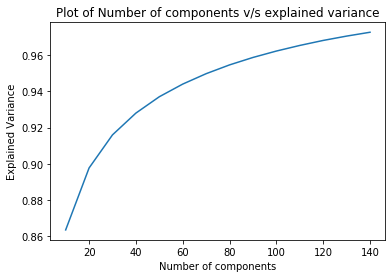

In [13]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    ###<your code>###
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f"Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}")

plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [16]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
###<your code>###
svd=TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [18]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 423 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 485 doesn't contain word in vocab_list



document 584 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 708 doesn't contain word in vocab_list



document 930 doesn't contain word in vocab_list



document 996 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 1090 doesn't contain word in vocab_list
east coast


document 2282 doesn't contain word in vocab_list
audrie lousy autocorrect


document 2355 doesn't contain word in vocab_list
erutupalam thandiyachu


document 2447 doesn't contain word in vocab_list
beerage


document 2617 doesn't contain word in vocab_list
k k congratulation


document 2992 doesn't contain word in vocab_list
u


document 3486 doesn't contain word in vocab_list
gibbs unsold mike hussey


document 3840 doesn't contain word in vocab_list
hanks lotsly


document 4421 doesn't contain word in v

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

###<your code>###
knn= KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred= knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
###<your code>###
test_pred= knn.predict(doc_vec_test)

In [26]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"test acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9716343989194057
test acc: 0.9631956912028725
